
#  Sequence-to-Sequence Learning for Machine Translation

In so-called sequence-to-sequence problems such as machine translation
(as discussed in :numref:`sec_machine_translation`),
where inputs and outputs each consist 
of variable-length unaligned sequences,
we generally rely on encoder--decoder architectures
(:numref:`sec_encoder-decoder`).
In this section,
we will demonstrate the application 
of an encoder--decoder architecture,
where both the encoder and decoder 
are implemented as RNNs,
to the task of machine translation
:cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014`.

Here, the encoder RNN will take a variable-length sequence as input 
and transform it into a fixed-shape hidden state.
Later, in :numref:`chap_attention-and-transformers`,
we will introduce attention mechanisms, 
which allow us to access encoded inputs
without having to compress the entire input
into a single fixed-length representation.

Then to generate the output sequence, 
one token at a time,
the decoder model, 
consisting of a separate RNN,
will predict each successive target token
given both the input sequence
and the preceding tokens in the output.
During training, the decoder will typically
be conditioned upon the preceding tokens
in the official "ground truth" label. 
However, at test time, we will want to condition
each output of the decoder on the tokens already predicted. 
Note that if we ignore the encoder,
the decoder in a sequence-to-sequence architecture 
behaves just like a normal language model.
:numref:`fig_seq2seq` illustrates
how to use two RNNs
for sequence-to-sequence learning
in machine translation.


![Sequence-to-sequence learning with an RNN encoder and an RNN decoder.](../img/seq2seq.svg)
:label:`fig_seq2seq`

In :numref:`fig_seq2seq`,
the special "&lt;eos&gt;" token
marks the end of the sequence.
Our model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions to be aware of:
First, we begin every input with a special 
beginning-of-sequence "&lt;bos&gt;" token.
Second, we may feed
the final hidden state of the encoder
into the decoder
at every single decoding time step :cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`.
In some other designs,
such as that of :citet:`Sutskever.Vinyals.Le.2014`,
the final hidden state of the RNN encoder
is used
to initiate the hidden state of the decoder
only at the first decoding step.

In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN
import d2lai: StackedRNN, AbstractEncoderDecoder

  Activating project at `/workspace/d2l-julia/d2lai`


## Teacher Forcing

While running the encoder on the input sequence
is relatively straightforward,
handling the input and output 
of the decoder requires more care. 
The most common approach is sometimes called *teacher forcing*.
Here, the original target sequence (token labels)
is fed into the decoder as input.
More concretely,
the special beginning-of-sequence token
and the original target sequence,
excluding the final token,
are concatenated as input to the decoder,
while the decoder output (labels for training) is
the original target sequence,
shifted by one token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;" (:numref:`fig_seq2seq`).

Our implementation in
:numref:`subsec_loading-seq-fixed-len`
prepared training data for teacher forcing,
where shifting tokens for self-supervised learning
is similar to the training of language models in
:numref:`sec_language-model`.
An alternative approach is
to feed the *predicted* token
from the previous time step
as the current input to the decoder.


In the following, we explain the design 
depicted in :numref:`fig_seq2seq`
in greater detail.
We will train this model for machine translation
on the English--French dataset as introduced in
:numref:`sec_machine_translation`.

## Encoder

Recall that the encoder transforms an input sequence of variable length
into a fixed-shape *context variable* $\mathbf{c}$ (see :numref:`fig_seq2seq`).


Consider a single sequence example (batch size 1).
Suppose the input sequence is $x_1, \ldots, x_T$, 
such that $x_t$ is the $t^{\textrm{th}}$ token.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ 
from the previous time step 
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express 
the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

In general, the encoder transforms 
the hidden states at all time steps
into a context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example, in :numref:`fig_seq2seq`,
the context variable is just the hidden state $\mathbf{h}_T$
corresponding to the encoder RNN's representation
after processing the final token of the input sequence.

In this example, we have used a unidirectional RNN
to design the encoder,
where the hidden state only depends on the input subsequence 
at and before the time step of the hidden state.
We can also construct encoders using bidirectional RNNs.
In this case, a hidden state depends on the subsequence before and after the time step 
(including the input at the current time step), 
which encodes the information of the entire sequence.


Now let's [**implement the RNN encoder**].
Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence.
The weight of an embedding layer is a matrix,
where the number of rows corresponds to 
the size of the input vocabulary (`vocab_size`)
and number of columns corresponds to 
the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer fetches the $i^{\textrm{th}}$ row 
(starting from 0) of the weight matrix
to return its feature vector.
Here we implement the encoder with a multilayer GRU.

In [2]:
struct Seq2SeqEncoder{E, R , A} <: AbstractModel 
    embedding::E
    rnn::R
    args::A
end

function Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers, dropout=0)
    embedding = Embedding(vocab_size => embed_size)
    rnn = StackedRNN(embed_size, num_hiddens, num_layers)
    args = (; vocab_size, embed_size, num_hiddens, num_layers)
    Seq2SeqEncoder(embedding, rnn, args)
end

function (m::Seq2SeqEncoder)(x, args)
    embs = m.embedding(x)
    out, state = m.rnn(embs)
    return out, state
end

Let's use a concrete example
to [**illustrate the above encoder implementation.**]
Below, we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given a minibatch of sequence inputs `X`
(batch size $=4$; number of time steps $=9$),
the hidden states of the final layer
at all the time steps
(`enc_outputs` returned by the encoder's recurrent layers)
are a tensor of shape
(number of time steps, batch size, number of hidden units).

In [3]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = ones(Int64, num_steps, batch_size)
enc_outputs, enc_state = encoder(X, nothing)
@assert size(enc_outputs) == (num_hiddens, num_steps, batch_size)

## Decoder

Given a target output sequence $y_1, y_2, \ldots, y_{T'}$
for each time step $t'$
(we use $t^\prime$ to differentiate from the input sequence time steps),
the decoder assigns a predicted probability
to each possible token occurring at step $y_{t'+1}$
conditioned upon the previous tokens in the target
$y_1, \ldots, y_{t'}$ 
and the context variable 
$\mathbf{c}$, i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.

To predict the subsequent token $t^\prime+1$ in the target sequence,
the RNN decoder takes the previous step's target token $y_{t^\prime}$,
the hidden RNN state from the previous time step $\mathbf{s}_{t^\prime-1}$,
and the context variable $\mathbf{c}$ as its input,
and transforms them into the hidden state 
$\mathbf{s}_{t^\prime}$ at the current time step.
We can use a function $g$ to express 
the transformation of the decoder's hidden layer:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

After obtaining the hidden state of the decoder,
we can use an output layer and the softmax operation 
to compute the predictive distribution
$p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$ 
over the subsequent output token ${t^\prime+1}$.

Following :numref:`fig_seq2seq`,
when implementing the decoder as follows,
we directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder 
have the same number of layers and hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
we use a fully connected layer
to transform the hidden state 
at the final layer of the RNN decoder.

In [4]:
struct Seq2SeqDecoder{E, R, D, A} <: AbstractModel
    embedding::E 
    rnn::R 
    dense::D
    args::A
end


function Seq2SeqDecoder(vocab_size::Int, embed_size::Int, num_hiddens, num_layers, dropout=0)
    embedding = Embedding(vocab_size => embed_size)
    rnn = StackedRNN(embed_size + num_hiddens, num_hiddens, num_layers; rnn = Flux.LSTM)
    dense = Dense(num_hiddens, vocab_size) 
    args = (; vocab_size, embed_size, num_hiddens, num_layers)
    Seq2SeqDecoder(embedding, rnn, dense, args)
end

function d2lai.init_state(::Seq2SeqDecoder, enc_all_out, args)
    enc_all_out
end
function (m::Seq2SeqDecoder)(x, state)
    embs = m.embedding(x) 
    enc_output, hidden_state = state 
    context = enc_output[:, end, :]
    context_copied = [copy(context) for i in 1:size(embs, 2)]
    context_hcat = reduce(hcat, context_copied)
    context_reshaped = reshape(context_hcat, :, size(embs, 2), size(embs, 3))
    embs_and_context = vcat(embs, context_reshaped)
    rnn_out, new_hidden_state = m.rnn(embs_and_context, hidden_state)
    outputs = m.dense(rnn_out) 
    return outputs, (enc_output, new_hidden_state)
end


To illustrate the implemented decoder,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the final dimension of the tensor stores the predicted token distribution.


In [5]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = d2lai.init_state(decoder, encoder(X, nothing), nothing)
decoder_out, state = decoder(X, state)
@assert size(decoder_out) == (vocab_size, num_steps, batch_size)
@assert size(state[1]) == (num_hiddens, num_steps, batch_size)

The layers in the above RNN encoder--decoder model 
are summarized in :numref:`fig_seq2seq_details`.

![Layers in an RNN encoder--decoder model.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`



## Encoder--Decoder for Sequence-to-Sequence Learning


Putting it all together in code yields the following:

In [6]:
struct Seq2Seq{E, D, T, A} <: d2lai.AbstractEncoderDecoder
    encoder::E 
    decoder::D 
    tgt_pad::T 
    args::A 
end 

function Seq2Seq(encoder::AbstractModel, decoder::AbstractModel, tgt_pad)
    return Seq2Seq(encoder, decoder, tgt_pad, (;))
end


Seq2Seq

In [7]:
function d2lai.training_step(m::AbstractEncoderDecoder, batch)
    y_pred = d2lai.forward(m, batch[1:end-1]...)
    loss_ = d2lai.loss(m, y_pred, batch[end])
    return loss_
end

function d2lai.validation_step(m::AbstractEncoderDecoder, batch)
    y_pred = d2lai.forward(m, batch[1:end-1]...)
    loss_ = d2lai.loss(m, y_pred, batch[end])
    return loss_ , nothing
end


## Loss Function with Masking

At each time step, the decoder predicts 
a probability distribution for the output tokens.
As with language modeling, 
we can apply softmax 
to obtain the distribution
and calculate the cross-entropy loss for optimization.
Recall from :numref:`sec_machine_translation`
that the special padding tokens
are appended to the end of sequences
and so sequences of varying lengths
can be efficiently loaded
in minibatches of the same shape.
However, prediction of padding tokens
should be excluded from loss calculations.
To this end, we can 
[**mask irrelevant entries with zero values**]
so that multiplication 
of any irrelevant prediction
with zero equates to zero.

In [8]:
function d2lai.loss(model::AbstractEncoderDecoder, y_pred, y)
    # Compute per-token cross entropy loss (shape: vocab × seq_len × batch)
    target_oh = Flux.onehotbatch(y, 1:model.decoder.args.vocab_size)
    loss = Flux.logitcrossentropy(y_pred, target_oh; agg = Flux.identity)

    # Create mask (ensure it's same type and device as loss)
    mask = reshape(y, 1, 9, :) .!= model.tgt_pad
    mask = eltype(loss).(mask)

    # Apply mask and normalize
    masked_loss = mask .* loss
    return sum(masked_loss) / (sum(mask) + eps(eltype(masked_loss)))  # to avoid divide-by-zero
end

# Training

Now we can create and train an RNN encoder--decoder model
for sequence-to-sequence learning on the machine translation dataset.


[ Info: Train Loss: 3.7725425, Val Loss: 4.8512206
[ Info: Train Loss: 2.9626951, Val Loss: 4.4104686
[ Info: Train Loss: 2.7549093, Val Loss: 4.4569564
[ Info: Train Loss: 2.4077005, Val Loss: 4.207527
[ Info: Train Loss: 2.120146, Val Loss: 4.7731814
[ Info: Train Loss: 1.8031303, Val Loss: 4.5170074
[ Info: Train Loss: 1.5689857, Val Loss: 4.5816607
[ Info: Train Loss: 1.3473984, Val Loss: 4.587737
[ Info: Train Loss: 1.2663335, Val Loss: 4.894618
[ Info: Train Loss: 1.1931585, Val Loss: 4.6093106
[ Info: Train Loss: 0.9825569, Val Loss: 4.663696
[ Info: Train Loss: 0.9533752, Val Loss: 4.8820148
[ Info: Train Loss: 0.8541412, Val Loss: 4.4741316
[ Info: Train Loss: 0.80364215, Val Loss: 4.884055
[ Info: Train Loss: 0.79689586, Val Loss: 4.9315615
[ Info: Train Loss: 0.7644792, Val Loss: 4.8976398
[ Info: Train Loss: 0.7273372, Val Loss: 4.635629
[ Info: Train Loss: 0.6961968, Val Loss: 4.9264054
[ Info: Train Loss: 0.67604417, Val Loss: 4.89318
[ Info: Train Loss: 0.6577363, Val Lo

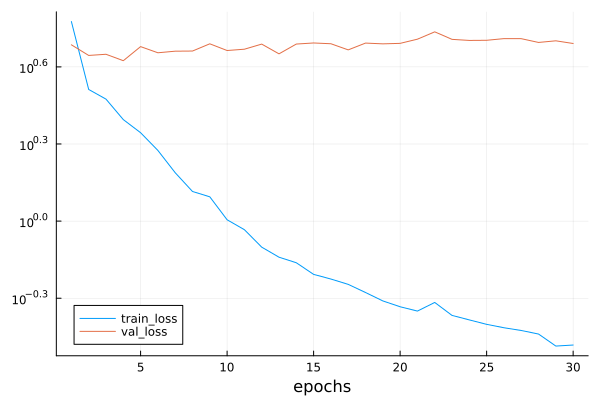

In [9]:
data = d2lai.MTFraEng(128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

encoder = Seq2SeqEncoder(length(data.src_vocab), embed_size, num_hiddens, num_layers)
decoder = Seq2SeqDecoder(length(data.tgt_vocab), embed_size, num_hiddens, 1)
model = Seq2Seq(encoder, decoder, data.tgt_vocab["<pad>"])

opt = Flux.Adam(0.01)
trainer = Trainer(model, data, opt; max_epochs = 30, gpu = true, gradient_clip_val = 1.)
m, _ = d2lai.fit(trainer);


## Prediction

To predict the output sequence
at each step, 
the predicted token from the previous
time step is fed into the decoder as an input.
One simple strategy is to sample whichever token
that has been assigned by the decoder the highest probability
when predicting at each step.
As in training, at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder.
This prediction process
is illustrated in :numref:`fig_seq2seq_predict`.
When the end-of-sequence ("&lt;eos&gt;") token is predicted,
the prediction of the output sequence is complete.


![Predicting the output sequence token by token using an RNN encoder--decoder.](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

In the next section, we will introduce 
more sophisticated strategies 
based on beam search (:numref:`sec_beam-search`).

In [10]:
function predict_step(model::AbstractEncoderDecoder, batch, device, num_steps)
    batch = batch |> device 
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = model.encoder(src, src_valid_len)
    dec_state = d2lai.init_state(model.decoder, enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[1:1, 1:end]], []
    for _ in 1:num_steps 
        Y_t = outputs[end]
        Y_t_plus_1, dec_state = model.decoder(Y_t, dec_state)
        Y_t_plus_1_index = getindex.(argmax(Y_t_plus_1, dims = 1), 1)
        push!(outputs, reshape(Y_t_plus_1_index, 1, :))
    end
    out = reduce(vcat, outputs)
    return out[2:end, :]
end

predict_step (generic function with 1 method)

## Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
target sequence (the ground truth).
But what precisely is the appropriate measure 
for comparing similarity between two sequences?


Bilingual Evaluation Understudy (BLEU),
though originally proposed for evaluating
machine translation results :cite:`Papineni.Roukos.Ward.ea.2002`,
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-gram (:numref:`subsec_markov-models-and-n-grams`) in the predicted sequence,
BLEU evaluates whether this $n$-gram appears
in the target sequence.

Denote by $p_n$ the precision of an $n$-gram,
defined as the ratio 
of the number of matched $n$-grams in
the predicted and target sequences
to the number of $n$-grams in the predicted sequence.
To explain, given a target sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Now let $\textrm{len}_{\textrm{label}}$ and $\textrm{len}_{\textrm{pred}}$
be the numbers of tokens in the target sequence 
and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

where $k$ is the longest $n$-gram for matching.

Based on the definition of BLEU in :eqref:`eq_bleu`,
whenever the predicted sequence is the same as the target sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
when a longer $n$-gram has high precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to yield a higher $p_n$ value,
the coefficient before the multiplication term in :eqref:`eq_bleu`
penalizes shorter predicted sequences.
For example, when $k=2$,
given the target sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We implement the BLEU measure as follows.


In [11]:
function bleu(pred_seq::String, label_seq::String, k::Int)
    
    pred_tokens = split(pred_seq)
    label_tokens = split(label_seq)
    len_pred = length(pred_tokens)
    len_label = length(label_tokens)
    
    # Brevity penalty
    score = exp(min(0.0, 1 - len_label / len_pred))
    
    for n in 1:min(k, len_pred)
        num_matches = 0
        label_subs = Dict{String, Int}()
        
        # Build reference n-gram counts
        for i in 1:(len_label - n + 1)
            ngram = join(label_tokens[i:i+n-1], " ")
            label_subs[ngram] = get(label_subs, ngram, 0) + 1
        end
        
        # Match predicted n-grams against reference
        for i in 1:(len_pred - n + 1)
            pred_ngram = join(pred_tokens[i:i+n-1], " ")
            if get(label_subs, pred_ngram, 0) > 0
                num_matches += 1
                label_subs[pred_ngram] -= 1
            end
        end
        
        # Update score with weighted precision
        score *= (num_matches / (len_pred - n + 1))^(0.5^n)
    end
    
    return score
end

bleu (generic function with 1 method)

In the end,
we use the trained RNN encoder--decoder
to translate a few English sentences into French
and compute the BLEU of the results.

In [13]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]


batch = d2lai.build(data, engs, fras)
preds = predict_step(m, batch, cpu, data.args.num_steps)

for (en, fr, p) in zip(engs, fras, eachcol(preds))
    translation = []
    for token in d2lai.to_tokens(data.tgt_vocab, p)
        if token == "<eos>"
            break
        end
        push!(translation, token)
    end 
    bleu_score = bleu(join(translation, " "), fr, 2)
    println("$en => $translation", "bleu: $bleu_score")
end

go . => Any["va", "!"]bleu: 1.0
i lost . => Any["j'ai", "perdu", "."]bleu: 1.0
he's calm . => Any["soyez", "calme", "", "!"]bleu: 0.0
i'm home . => Any["je", "suis", "chez", "moi", "."]bleu: 1.0
